# Notebook Objectives

In this notebooks, we'll go through the main behavioral analysis results.

Results include:
* ?
* ?

---
# Setup


In [ ]:
# @title Imports
import os
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LassoCV, Lasso
from scipy import stats


from popy.io_tools import *
from popy.behavior_data_tools import *
from popy.neural_data_tools import time_normalize_session, scale_neural_data, remove_low_fr_neurons, remove_trunctuated_neurons
from popy.decoding.decoder_tools import *
from popy.plotting.plotting_tools import *
#from popy.plotting.plot_behavior import show_target_selection 
import popy.config as cfg

PATH = cfg.PROJECT_PATH_LOCAL


In [1]:
##% data loading
def load_data_for_decoder(monkey, session, n_extra_trials=(-1, 1)):
      # 1. Behavior data

      # Load behavior data
      behav = load_behavior(monkey, session)
      behav = drop_time_fields(behav)

      # add behav vars to decode
      behav = add_value_function(behav)  # add value function for its decoding
      for i in range(1, 9):
            behav[f'R_{i}'] = behav['feedback'].shift(i)  # feedback of previous trial
      fb_sequence = [np.nan, np.nan, np.nan]
      for i, row in behav[3:].iterrows():
            R_1 = behav.loc[i-1, 'feedback']
            R_2 = behav.loc[i-2, 'feedback']
            R_3 = behav.loc[i-3, 'feedback']
            # to binary
            fb_sequence.append(R_3 + 2*R_2 + 4*R_1)
      behav['fb_sequence'] = fb_sequence

      behav = behav.dropna()

      # 2. Neural data

      # Load neural data
      neural_data = load_neural_data(monkey, session, hz=1000)

      # remove some units
      neural_data = remove_low_fr_neurons(neural_data, 1, print_usr_msg=False)
      neural_data = remove_trunctuated_neurons(neural_data, mode='remove', delay_limit=10, print_usr_msg=False)

      # process neural data
      neural_data = add_firing_rates(neural_data, drop_spike_trains=True, method='gauss', std=.05)
      neural_data = downsample_time(neural_data, 100)
      neural_data = scale_neural_data(neural_data)
      neural_data = time_normalize_session(neural_data)

      # 3. build neural dataset and merge with behavior
      neural_dataset = build_trial_dataset(neural_data, mode='full_trial', n_extra_trials=n_extra_trials)
      neural_dataset = merge_behavior(neural_dataset, behav)

      '''print(f"Monkey: {monkey}, Session: {session}\n",
            f"Removed {n_units_all - n_units_kept} / {n_units_all} neurons\n")'''

      return neural_dataset, behav

In [2]:
# @title Plotting Functions
# plot residuals in time
def plot_residuals_time(data_projected, residuals, monkey, session):
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))

        win = np.ones(40) / 40
        residuals_smooth = np.convolve(residuals, np.ones(10)/10, mode='valid')

        ax.plot(data_projected.trial_id[:len(residuals_smooth)], 
                residuals_smooth,
                color='black', label='Smoothed residuals (win=40 trials)')
        ax.scatter(data_projected.trial_id[:len(residuals)], residuals, color='grey', alpha=.5, label='Residuals', s=5)
        ax.axhline(0, color='grey', linestyle='--')

        ax.legend()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('Trial')
        ax.set_ylabel('Residual')

        plt.suptitle(f'{monkey} {session}')

        plt.show()
        
def plot_residuals(behavioral_value, neural_value, residuals, fit_line, monkey, session):
    fig, ax = plt.subplots(figsize=(5, 5))

    cbar = plt.scatter(behavioral_value, neural_value, c=residuals, cmap='coolwarm', s=10)
    # colorbar w title 'residuals'
    plt.colorbar(cbar, label='Residuals')

    plt.plot(behavioral_value, np.polyval(fit_line, behavioral_value), color='grey', linestyle='--')

    ax.set_xlabel('Behavioral value')
    ax.set_ylabel('Neural value')
    ax.set_title(f'{monkey} {session}')

    plt.show()

def green_red_plot_stats(neural_value_dataset, title=None):
    # distribution of pos and neg feedback along neural  value
    fig, axs = plt.subplots(1, 3, figsize=(15, 6))
    
    monkey = neural_value_dataset.monkey.values[0]
    session = neural_value_dataset.session.values[0]
    if title is not None:
        fig.suptitle(title+f'\n{monkey} {session}')

    # get neural  value for the current trial and the previous one
    neural_value = neural_value_dataset.values

    # minmax scale 
    neural_value = (neural_value - np.min(neural_value)) / (np.max(neural_value) - np.min(neural_value))

    # get q_t and q_{t-1}
    q_curr = neural_value[1:]
    q_prev = neural_value[:-1]

    # corresponding feedback vector
    fb_vector = neural_value_dataset.feedback.values[:-1]

    ax = axs[0]
    # balance q_curr to have equal number of pos and neg feedback
    n_min = min(np.sum(fb_vector == 1), np.sum(fb_vector == 0))
    q_curr_pos_sample = np.random.choice(q_curr[fb_vector == 1], n_min, replace=False)
    q_curr_neg_sample = np.random.choice(q_curr[fb_vector == 0], n_min, replace=False)

    ax.hist(q_curr_pos_sample, color='tab:green', alpha=.5, label='fb positive')
    ax.hist(q_curr_neg_sample, color='tab:red', alpha=.5, label='fb negative')
    ax.set_xlabel('Neural  value at time=t\n $q_t$')
    ax.set_xlim(0, 1)
    ax.set_ylabel('Count')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # distribution of change in  value for each feedback
    ax = axs[1]
    # balance q_diff to have equal number of pos and neg feedback
    n_min = min(np.sum(fb_vector == 1), np.sum(fb_vector == 0))
    q_diff = q_curr - q_prev
    q_diff_pos_sample = np.random.choice(q_diff[fb_vector == 1], n_min, replace=False)
    q_diff_neg_sample = np.random.choice(q_diff[fb_vector == 0], n_min, replace=False)

    ax.hist(q_diff_pos_sample, color='tab:green', alpha=.5, label='fb positive')
    ax.hist(q_diff_neg_sample, color='tab:red', alpha=.5, label='fb negative')
    # line at 0 and means
    ax.axvline(0, color='k', linestyle='--')
    ax.axvline(np.mean(q_diff[fb_vector == 1]), color='tab:green', linestyle='--', label='mean fb positive')
    ax.axvline(np.mean(q_diff[fb_vector == 0]), color='tab:red', linestyle='--', label='mean fb negative')

    ax.set_xlabel('Change in neural  value \n$\Delta q = q_t - q_{t-1}$')
    ax.set_xlim(-.7, .7)

    ax.set_ylabel('Count')
    # legend below plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # change in  value vs RPE
    RPE_neural = fb_vector - q_prev

    ax = axs[2]
    n_min = min(np.sum(fb_vector == 1), np.sum(fb_vector == 0))
    ids_sample_pos = np.random.choice(np.where(fb_vector == 1)[0], n_min, replace=False)
    ids_sample_neg = np.random.choice(np.where(fb_vector == 0)[0], n_min, replace=False)

    ax.scatter(q_diff[ids_sample_pos], q_prev[ids_sample_pos], color='tab:green', alpha=.5)
    ax.scatter(q_diff[ids_sample_neg], q_prev[ids_sample_neg], color='tab:red', alpha=.5)
    # line at 0
    ax.axvline(0, color='k', linestyle='--')
    ax.axhline(0, color='k', linestyle='--')
    # legend
    ax.scatter([], [], color='tab:green', label='fb positive')
    ax.scatter([], [], color='tab:red', label='fb negative')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
    ax.set_ylabel('Neural  value at time=t-1\n $q_{t-1}$')
    ax.set_xlabel('Change in neural value \n$\Delta q = q_t - q_{t-1}$')
    ax.set_xlim(-.7, .7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # both axes from -1 to 1

    plt.tight_layout()
    plt.show()

def plot_decoder_results(results, weights, unit_names, n_extra_trials):
    fig, axs = plt.subplots(1, 3, figsize=(13, 4), sharex=True)

    ax = axs[0]
    ax.plot(results.time, results)
    ax.axhline(.5, color='k', linestyle='--')
    plot_keypoints(ax, n_extra_trials, fontsize=8)
    ax.grid(axis='x')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('R2')
    ax.set_xlabel('Time')
    ax.set_title('R2 score')
    # add colorbar
    ax.set_title('decoder performance (cross val)')

    ax = axs[1]
    # plot bar below
    pbar = ax.imshow(weights.data.T, aspect='auto', cmap='RdBu', extent=[results.time.min(), results.time.max(), 0-.5, len(unit_names)-.5], origin='lower', vmin=-np.max(np.abs(weights.data)*.5), vmax=np.max(np.abs(weights.data)*.5))
    plt.colorbar(pbar, ax=ax, pad=0.005, fraction=.05)
    
    plot_keypoints(ax, n_extra_trials, fontsize=8)
    ax.grid(axis='x', alpha=.5, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Time')
    ax.set_ylabel('Unit')
    '''ax.set_yticks(range(len(unit_names)))
    ax.set_yticklabels(unit_names, fontsize=5)'''
    ax.set_title('Weights')

    ax = axs[2]
    pbar = ax.imshow(np.corrcoef(weights.data), cmap='PuOr', vmin=-.5, vmax=.5, extent=[weights.time.min(), weights.time.max(), weights.time.min(), weights.time.max()], aspect='auto', origin='lower', interpolation='gaussian') 
    plt.colorbar(pbar, ax=ax, pad=0.005, fraction=.05)
    plot_keypoints(ax, (-1, 0), axis='both', fontsize=8)
    ax.grid(alpha=.8, linestyle='--')
    ax.set_xlabel('time')
    ax.set_ylabel('time')
    ax.set_title('Weight correlation matrix')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()

    return fig, axs

def plot_projected_data(data_projected, title, n_extra_trials):
    # project to axis
    h = 9  # in cm
    w = 12  # in cm

    fig, ax = plt.subplots(figsize=(w/2.54, h/2.54))

    time_vector = data_projected.time.values

    unique_fb_sequences = np.sort(np.unique(data_projected.fb_sequence.data))

    # bwr colormap, n=8 sampples RdYlGn
    colors = sns.color_palette("RdYlGn", len(unique_fb_sequences))[::-1]
    alphas = [1-i for i in np.linspace(0, 1, len(unique_fb_sequences))]
    labels = ["[-, -, -]", "[+, -, -]", "[-, +, -]", "[+, +, -]", "[-, -, +]", "[+, -, +]", "[-, +, +]", "[+, +, +]"][::-1]

    full_mean = np.mean(data_projected, axis=0)

    for i, label in enumerate(unique_fb_sequences[::-1]):
        class_mean = np.mean(data_projected.where(data_projected.fb_sequence == label), axis=0)
        ax.plot(time_vector, class_mean - full_mean, color=colors[i], label=labels[i], linewidth=1, alpha=.7)

    # add behav keyboints
    plot_keypoints(ax, n_extra_trials)
    # y grid only
    ax.grid(axis='x', alpha=.5, linestyle='--')
    ax.axhline(0, color='k', linestyle='-', alpha=.5)

    # remove left and top spines
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)
    # move legemd outside
    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # save as svg
    ax.set_ylabel('neural value')
    '''if title is not None:
        ax.set_title(title)
    else:
        ax.set_title('Neural value')'''
    
    #ax.set_xlim([1, 5])

    return fig, ax

def green_red_plot(neural_value_dataset):
    # get neural value for the current trial and the previous one
    neural_value = neural_value_dataset.values

    # minmax scale 
    neural_value = (neural_value - np.min(neural_value)) / (np.max(neural_value) - np.min(neural_value))

    q_curr = neural_value[1:]
    q_prev = neural_value[:-1]

    # corresponding feedback vector
    fb_vector = neural_value_dataset.feedback.values[:-1]

    # plot value function at each point, color coded by feedback, connected by lines
    fig, ax = plt.subplots(figsize=(5, 5))

    # plot value function
    ax.scatter(np.zeros(len(q_prev)), q_prev, color='grey', s=.1)
    ax.scatter(np.ones(len(q_curr)), q_curr, color='grey', s=.1)

    # plot lines
    for i in range(len(q_prev)):
        ax.plot([0, 1], [q_prev[i], q_curr[i]], color='tab:green' if fb_vector[i] == 1 else 'tab:red', alpha=.1)

    # legend
    ax.plot([], [], color='tab:green', label='correct')
    ax.plot([], [], color='tab:red', label='incorrect')
    ax.legend(frameon=False)

    # labels
    ax.set_xlabel('trial')
    #xlabels: 0= trial t-1, 1=trial t
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['t-1', 't'])

    ax.set_ylabel('Neural value\n$q$')

    # title
    monkey = neural_value_dataset.monkey.values[0]
    session = neural_value_dataset.session.values[0]
    ax.set_title(f"monkey: {monkey}, session: {session}")

    return fig, ax

In [3]:
# @title Helper Functions
def project_data(neural_dataset, weights_best):
    data_projected = np.array([neural_dataset.firing_rates.values[trial, :, :].T @ weights_best for trial in range(neural_dataset.firing_rates.shape[0])])

    # write back to xarray, preserve the trial and time dimensions and corresponding coordinates
    time_coords = {name: coord for name, coord in neural_dataset.coords.items() if 'time' in coord.dims}
    trial_coords = {name: coord for name, coord in neural_dataset.coords.items() if 'trial_id' in coord.dims}

    # Create a DataArray with the projected data
    data_projected_da = xr.DataArray(data_projected, dims=('trial_id', 'time'), coords={**trial_coords, **time_coords})

    return data_projected_da

def bin_sequence_to_decimal(list):
    """
    Takes a list of 0s and 1s and converts it to a binary number. eg. [0, 0, 1] -> 4
    """
    # if any nan
    if any([pd.isna(x) for x in list]):
        return np.nan
    
    x = 0
    for he, digit in enumerate(list):
        x += digit * 2**he
    return int(x)

def custom_load_neural_data(monkey, session):
    # Load neural data
    neural_data = load_neural_data(monkey, session, return_dataset_format=True)

    # get area
    neural_data = neural_data.sel(unit=neural_data.area == 'MCC')

    neural_data = remove_trunctuated_neurons(neural_data, delay_limit=10)

    # remove low_firing units
    neural_data = remove_low_fr_neurons(neural_data, 1)

    # add firing rates
    neural_data = add_firing_rates(neural_data)

    # normalize neural data in time
    neural_data = time_normalize_session(neural_data)

    return neural_data

def custom_load_behavior(monkey, session):
    session_data = get_behavior(monkey, session)

    # add fb-1, fb-2, ...
    session_data['R_1'] = session_data['feedback'].shift(1)
    session_data['R_2'] = session_data['feedback'].shift(2)
    session_data['R_3'] = session_data['feedback'].shift(3)
    session_data['R_4'] = session_data['feedback'].shift(4)

    # add label that marks the sequence of the last 3 outcomes
    n_binary = 3
    fb_sequence = np.array([np.nan, np.nan] + [bin_sequence_to_decimal(session_data.feedback[i:i+n_binary])
                for i in range(len(session_data.feedback)-n_binary+1)])
    session_data['fb_sequence'] = fb_sequence
    session_data['fb_sequence'] = session_data['fb_sequence'].shift(+1)

    # switch information, etc
    session_data = add_switch_info(session_data)
    session_data = add_value_function(session_data, monkey=monkey)
    #session_data = add_value_anna(session_data, 'fss_01')
    session_data = add_trials_since_switch(session_data)
    session_data = add_reaction_time(session_data)
    session_data = add_phase_info(session_data, exploration_limit=6, transition_limit=0)

    # clean up data
    session_data = drop_time_fields(session_data)  # remove time fields
    session_data = session_data.dropna()

    # convert to bool, necessary later
    session_data['R_1'] = session_data['R_1'].astype('bool')
    session_data['R_2'] = session_data['R_2'].astype('bool')
    session_data['R_3'] = session_data['R_3'].astype('bool')
    session_data['R_4'] = session_data['R_4'].astype('bool')
    session_data['switch'] = session_data['switch'].astype('bool')
    session_data['fb_sequence'] = session_data['fb_sequence'].astype('int')

    return session_data

def find_best_penalty(neural_dataset, target='R_1', group=None):
    X = neural_dataset.firing_rates.values
    y = neural_dataset[target].values
    if group is not None:
        y_group = neural_dataset[group].values

    # create decoder, logistic regression resolved in time
    alphas = np.logspace(-4, 4, 10)
    clf = LassoCV(n_alphas=10, cv=10, n_jobs=-1)#penalty='l1', solver='liblinear', C=.1, max_iter=1000)

    scores, alphas, weights = [], [], []
    for t in range(X.shape[2]):
        if t%100 == 0:
            print(f"Time: {t}/{X.shape[2]}")
        X_temp = X[:, :, t]

        clf.fit(X_temp, y)
        score = clf.score(X_temp, y)
        
        scores.append(score)
        alphas.append(clf.alpha_)
        weights.append(clf.coef_)

    # convert to numpy array
    alphas = np.array(alphas).squeeze()
    scores = np.array(scores).squeeze()
    weights = np.array(weights).squeeze()

    # create an xarray
    alphas = xr.DataArray(alphas, dims=('time'), coords={'time': neural_dataset.time.values})
    scores = xr.DataArray(scores, dims=('time'), coords={'time': neural_dataset.time.values})
    weights = xr.DataArray(weights, dims=('time', 'unit'), coords={'time': neural_dataset.time.values, 'unit': neural_dataset.unit.values})

    return alphas, scores, weights


def time_resolved_decoder(neural_dataset, target='R_1', group=None, t_project=3.5):
    trial_ids = neural_dataset.trial_id.values
    labels = neural_dataset[target].values  
    cv = 10

    # create train and test splits
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    clf = LogisticRegression()

    coeffs_all = []
    scores_all = []
    projected_data = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(trial_ids, labels)):
        ## 1. Fit and score the model

        # get labels of this fold
        y_train = neural_dataset[target].sel(trial_id=train_idx).values
        y_test = neural_dataset[target].sel(trial_id=test_idx).values

        coeffs_fold = []
        scores_fold = []
        for t in neural_dataset.time.values:
            # get the firing rates for the current time point
            X_train_temp = neural_dataset.firing_rates.sel(trial_id=train_idx, time=t).values
            X_test_temp = neural_dataset.firing_rates.sel(trial_id=test_idx, time=t).values

            # fit the model
            clf.fit(X_train_temp, y_train)
            score = clf.score(X_test_temp, y_test)

            # Store coefficients and R² score
            coeffs_fold.append(clf.coef_)
            scores_fold.append(score)

        coeffs_all.append(coeffs_fold)
        scores_all.append(scores_fold)

        ## 2. project test data to decision boundary at t=3.5
        neural_dataset_train = neural_dataset.sel(trial_id=train_idx)
        neural_dataset_test = neural_dataset.sel(trial_id=test_idx)

        # fit the model
        X_train_temp = neural_dataset_train.firing_rates.sel(time=t_project).values
        clf.fit(X_train_temp, y_train)

        # project test data
        X_test_temp = neural_dataset_test.firing_rates.values
        data_projected = np.array([X_test_temp[trial, :, :].T @ clf.coef_.squeeze() for trial in range(X_test_temp.shape[0])])

        # write back to xarray, preserve the trial and time dimensions and corresponding coordinates
        time_coords = {name: coord for name, coord in neural_dataset_test.coords.items() if 'time' in coord.dims}
        trial_coords = {name: coord for name, coord in neural_dataset_test.coords.items() if 'trial_id' in coord.dims}
        # Create a DataArray with the projected data
        data_projected_da = xr.DataArray(data_projected, dims=('trial_id', 'time'), coords={**trial_coords, **time_coords})
        # add to list
        projected_data.append(data_projected_da.copy())
            
    # convert to numpy array
    coeffs_all = np.array(coeffs_all).squeeze()
    scores_all = np.array(scores_all).squeeze()

    # average over folds
    coeffs_all = np.mean(coeffs_all, axis=0)
    scores_all = np.mean(scores_all, axis=0)

    # create an xarray
    results = xr.DataArray(scores_all, dims=('time'), coords={'time': neural_dataset.time.values})
    weights = xr.DataArray(coeffs_all, dims=('time', 'unit'), coords={'time': neural_dataset.time.values, 'unit': neural_dataset.unit.values})

    # concatenate projected data
    projected_data = xr.concat(projected_data, dim='trial_id')

    return results, weights, projected_data



---
# Get data

In [4]:
'''from popy.config import PROJECT_PATH_LOCAL as base_path

floc = os.path.join(base_path, 'data', 'results', 'mean_r2.pkl')
vals = pd.read_pickle(floc)
vals.sort_values(by='mean_R2', ascending=False).head(10)'''

"from popy.config import PROJECT_PATH_LOCAL as base_path\n\nfloc = os.path.join(base_path, 'data', 'results', 'mean_r2.pkl')\nvals = pd.read_pickle(floc)\nvals.sort_values(by='mean_R2', ascending=False).head(10)"

In [5]:
'''monkey, session = 'ka', '210322'
n_extra_trials = (0, 0)
neural_dataset, behav = load_data_for_decoder(monkey, session, n_extra_trials)'''

"monkey, session = 'ka', '210322'\nn_extra_trials = (0, 0)\nneural_dataset, behav = load_data_for_decoder(monkey, session, n_extra_trials)"

In [6]:
floc = os.path.join(PATH, 'data', 'processed', 'neural_data', 'meta_rates_20')
neural_dataset =  xr.open_dataset(floc + '/meta_rates.nc')

monkey, area = 'po', 'LPFC'

neural_dataset = neural_dataset.sel(unit=neural_dataset.area == area)
neural_dataset = neural_dataset.sel(unit=neural_dataset.monkey == monkey)

history_of_feedback = neural_dataset.history_of_feedback.values
# shuffle the history of feedback, but preserve classes
#label_mapping = {0: 5, 1: 2, 2: 7, 3: 0, 4: 1, 5: 3, 6: 4, 7: 6}
#history_of_feedback = [label_mapping[hist] for hist in history_of_feedback]


neural_dataset = neural_dataset.assign_coords(R_1=('trial_id', [0 if hist in [0, 1, 2, 3] else 1 for hist in neural_dataset.history_of_feedback.values]))
neural_dataset = neural_dataset.assign_coords(R_2=('trial_id', [0 if hist in [0, 1, 4, 5] else 1 for hist in neural_dataset.history_of_feedback.values]))
neural_dataset = neural_dataset.assign_coords(R_3=('trial_id', [0 if hist in [0, 2, 4, 6] else 1 for hist in neural_dataset.history_of_feedback.values]))
neural_dataset = neural_dataset.assign_coords(fb_sequence=('trial_id', history_of_feedback))
neural_dataset




NameError: name 'os' is not defined

In [ ]:
# normalize neural dataset
neural_data = neural_dataset.firing_rates.values

# Create a copy to avoid modifying the original data
normalized_data = np.zeros_like(neural_data)

# Loop through each neuron
for i in range(neural_data.shape[1]):
    # Get all data for this neuron across trials and timepoints
    neuron_data = neural_data[:, i, :]
    
    # Calculate mean and std across all values for this neuron
    mean_val = np.mean(neuron_data)
    std_val = np.std(neuron_data)
    
    # Avoid division by zero
    if std_val == 0:
        std_val = 1
        print(f"Warning: Neuron {i} has zero standard deviation")
    
    # Z-score normalize and store in the output array
    normalized_data[:, i, :] = (neuron_data - mean_val) / std_val

neural_dataset.firing_rates.values = normalized_data

neural_dataset

<xarray.Dataset>
Dimensions:              (unit: 445, time: 1500, trial_id: 160)
Coordinates: (12/14)
    unit_id_original     (unit) int64 ...
    channel              (unit) int64 ...
    area                 (unit) object 'LPFC' 'LPFC' 'LPFC' ... 'LPFC' 'LPFC'
  * time                 (time) float64 -7.5 -7.49 -7.48 ... 7.47 7.48 7.49
    epoch                (time) float64 ...
  * unit                 (unit) object 'po_040322_LPFC_03_01' ... 'po_310822_...
    ...                   ...
    history_of_feedback  (trial_id) float64 0.0 0.0 0.0 0.0 ... 7.0 7.0 7.0 7.0
  * trial_id             (trial_id) int64 0 1 2 3 4 5 ... 155 156 157 158 159
    R_1                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    R_2                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    R_3                  (trial_id) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1
    fb_sequence          (trial_id) float64 0.0 0.0 0.0 0.0 ... 7.0 7.0 7.0 7.0
Data variables:
    firing_rates         (trial_id, unit, time) float64 -0.8856 ... -0.5528
Attributes:
    bin_size:  0.01

---
# Section 1: Projection to value subspace

## Define the value subspace

In [ ]:
'''alphas_best, scores_best, weights_best = find_best_penalty(neural_dataset, target='fb_sequence', group=None)

# plot decoder results'''

'''# plot alphas
fig, ax = plt.subplots(figsize=(5, 3))
alphas_smooth = alphas_best#np.convolve(alphas_best.data, np.ones(10)/10, mode='same')
ax.plot(alphas_best.time, alphas_smooth)
plot_keypoints(ax, (-1, 0), fontsize=8)
ax.grid(axis='x')
ax.set_xlabel('Time')   
ax.set_ylabel('Alpha')
ax.set_title('Alpha')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

t = 3.5
print(f'mean best alpha at t={t}: {np.mean(alphas_best.data[np.abs(alphas_best.time - t) < .1])}')

# plot scores
fig, ax = plt.subplots(figsize=(5, 3))
scores_smooth = scores_best#np.convolve(scores_best.data, np.ones(10)/10, mode='same')
ax.plot(scores_best.time, scores_smooth)
plot_keypoints(ax, (-1, 0), fontsize=8)
ax.grid(axis='x')
ax.set_xlabel('Time')
ax.set_ylabel('Score')  
ax.set_title('Score')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# plot weights
fig, ax = plt.subplots(figsize=(3, 3))
pbar = ax.imshow(weights_best.data.T, aspect='auto', cmap='RdBu', extent=[weights_best.time.min(), weights_best.time.max(), 0-.5, len(weights_best.unit.values)-.5], origin='lower', vmin=-.1, vmax=.1)
plt.colorbar(pbar, ax=ax, pad=0.005, fraction=.05)
plot_keypoints(ax, (-1, 0), axis='x', fontsize=8)
ax.grid(axis='x', alpha=.5, linestyle='--')
ax.set_xlabel('Time')   
ax.set_ylabel('Unit')
ax.set_title('Weights')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()'''

"# plot alphas\nfig, ax = plt.subplots(figsize=(5, 3))\nalphas_smooth = alphas_best#np.convolve(alphas_best.data, np.ones(10)/10, mode='same')\nax.plot(alphas_best.time, alphas_smooth)\nplot_keypoints(ax, (-1, 0), fontsize=8)\nax.grid(axis='x')\nax.set_xlabel('Time')   \nax.set_ylabel('Alpha')\nax.set_title('Alpha')\nax.spines['top'].set_visible(False)\nax.spines['right'].set_visible(False)\nplt.show()\n\nt = 3.5\nprint(f'mean best alpha at t={t}: {np.mean(alphas_best.data[np.abs(alphas_best.time - t) < .1])}')\n\n# plot scores\nfig, ax = plt.subplots(figsize=(5, 3))\nscores_smooth = scores_best#np.convolve(scores_best.data, np.ones(10)/10, mode='same')\nax.plot(scores_best.time, scores_smooth)\nplot_keypoints(ax, (-1, 0), fontsize=8)\nax.grid(axis='x')\nax.set_xlabel('Time')\nax.set_ylabel('Score')  \nax.set_title('Score')\nax.spines['top'].set_visible(False)\nax.spines['right'].set_visible(False)\nplt.show()\n\n# plot weights\nfig, ax = plt.subplots(figsize=(3, 3))\npbar = ax.imshow(

In [ ]:
results, weights, data_projected = time_resolved_decoder(neural_dataset, target='R_1', t_project=3.5)

fig, axs = plot_decoder_results(results, weights, unit_names=neural_dataset.unit.values, n_extra_trials=(-1, 0))

plt.suptitle(f'{monkey} {area} - decoding R_1')
plt.tight_layout()

In [ ]:
data_projected

<xarray.DataArray (trial_id: 160, time: 1500)>
array([[-1.46621694, -1.76511741, -2.14012341, ...,  1.34466379,
         1.44571861,  1.45640468],
       [ 1.08282805,  1.18509883,  1.36460173, ..., -1.2544929 ,
        -1.09718175, -0.90277874],
       [ 1.26505454,  0.9909702 ,  0.69096089, ...,  0.076258  ,
        -0.14416651, -0.36574467],
       ...,
       [-0.91267408, -0.7599639 , -0.30916205, ..., -1.05752374,
        -1.19520179, -1.30677457],
       [-2.21768116, -2.1174014 , -2.23609988, ..., -0.16601569,
        -0.3682971 , -0.51630959],
       [-1.0930076 , -1.09957593, -0.55687616, ...,  1.65499212,
         1.86127032,  2.0268128 ]])
Coordinates:
    history_of_feedback  (trial_id) float64 0.0 0.0 1.0 1.0 ... 6.0 6.0 6.0 7.0
  * trial_id             (trial_id) int64 1 8 22 32 41 ... 108 131 135 138 147
    R_1                  (trial_id) int64 0 0 0 0 0 0 0 0 1 ... 1 1 1 1 1 1 1 1
    R_2                  (trial_id) int64 0 0 0 0 1 1 1 1 0 ... 0 0 0 0 1 1 1 1
    R_3                  (trial_id) int64 0 0 1 1 0 0 1 1 0 ... 0 0 1 1 0 0 0 1
    fb_sequence          (trial_id) float64 0.0 0.0 1.0 1.0 ... 6.0 6.0 6.0 7.0
  * time                 (time) float64 -7.5 -7.49 -7.48 ... 7.47 7.48 7.49
    epoch                (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0

Text(0.5, 0.98, 'ka MCC')

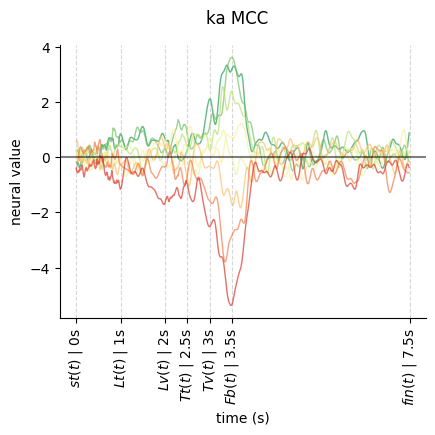

In [ ]:
fig, ax = plot_projected_data(data_projected.sel(time=slice(0, 7.5)), n_extra_trials=(0, 0), title=None)
plt.suptitle(f'{monkey} {area}')

---
# Section 2: Analysis of the neural value representation

## Green red plot: Value evolves according to feedback

In [ ]:
data_projected

<xarray.DataArray (trial_id: 160, time: 1500)>
array([[-1.46621694, -1.76511741, -2.14012341, ...,  1.34466379,
         1.44571861,  1.45640468],
       [ 1.08282805,  1.18509883,  1.36460173, ..., -1.2544929 ,
        -1.09718175, -0.90277874],
       [ 1.26505454,  0.9909702 ,  0.69096089, ...,  0.076258  ,
        -0.14416651, -0.36574467],
       ...,
       [-0.91267408, -0.7599639 , -0.30916205, ..., -1.05752374,
        -1.19520179, -1.30677457],
       [-2.21768116, -2.1174014 , -2.23609988, ..., -0.16601569,
        -0.3682971 , -0.51630959],
       [-1.0930076 , -1.09957593, -0.55687616, ...,  1.65499212,
         1.86127032,  2.0268128 ]])
Coordinates:
    history_of_feedback  (trial_id) float64 0.0 0.0 1.0 1.0 ... 6.0 6.0 6.0 7.0
  * trial_id             (trial_id) int64 1 8 22 32 41 ... 108 131 135 138 147
    R_1                  (trial_id) int64 0 0 0 0 0 0 0 0 1 ... 1 1 1 1 1 1 1 1
    R_2                  (trial_id) int64 0 0 0 0 1 1 1 1 0 ... 0 0 0 0 1 1 1 1
    R_3                  (trial_id) int64 0 0 1 1 0 0 1 1 0 ... 0 0 1 1 0 0 0 1
    fb_sequence          (trial_id) float64 0.0 0.0 1.0 1.0 ... 6.0 6.0 6.0 7.0
  * time                 (time) float64 -7.5 -7.49 -7.48 ... 7.47 7.48 7.49
    epoch                (time) float64 0.0 0.0 0.0 0.0 0.0 ... 5.0 5.0 5.0 5.0

In [ ]:
#neural_value_dataset = data_projected.sel(time=t_best_repres)
#fig, ax = green_red_plot(neural_value_dataset)

In [ ]:
# get neural value for the current trial and the previous one
#data_projected_norm = data_projected.values
#neural_value = (neural_value - np.min(neural_value)) / (np.max(neural_value) - np.min(neural_value))

# get neural value for the current trial and the previous one
V_t = data_projected.sel(time=3.5).values
V_t_m1 = data_projected.sel(time=-4).values
dv = V_t - V_t_m1
R_t_m1 = data_projected.R_1.values

'\nmonkey = neural_value_dataset.monkey.values[0]\nsession = neural_value_dataset.session.values[0]\nax.set_title(f"monkey: {monkey}, session: {session}")\n'

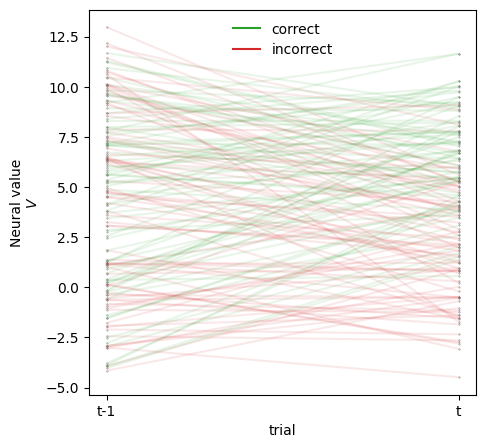

In [ ]:
# plot value function at each point, color coded by feedback, connected by lines
fig, ax = plt.subplots(figsize=(5, 5))

# plot value function
ax.scatter(np.zeros(len(V_t_m1)), V_t_m1, color='grey', s=.1)
ax.scatter(np.ones(len(V_t)), V_t, color='grey', s=.1)

# plot lines
for i in range(len(V_t_m1)):
    ax.plot([0, 1], [V_t_m1[i], V_t[i]], color='tab:green' if R_t_m1[i] == 1 else 'tab:red', alpha=.1)

# legend
ax.plot([], [], color='tab:green', label='correct')
ax.plot([], [], color='tab:red', label='incorrect')
ax.legend(frameon=False)

# labels
ax.set_xlabel('trial')
#xlabels: 0= trial t-1, 1=trial t
ax.set_xticks([0, 1])
ax.set_xticklabels(['t-1', 't'])

ax.set_ylabel('Neural value\n$V$')

# title
'''
monkey = neural_value_dataset.monkey.values[0]
session = neural_value_dataset.session.values[0]
ax.set_title(f"monkey: {monkey}, session: {session}")
'''

/var/folders/27/vz2x5s696jv_fnk5tpw5z1gw0000gn/T/ipykernel_42353/3593835505.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=fb_sequence, y=q_curr, palette='RdYlGn', ax=ax)


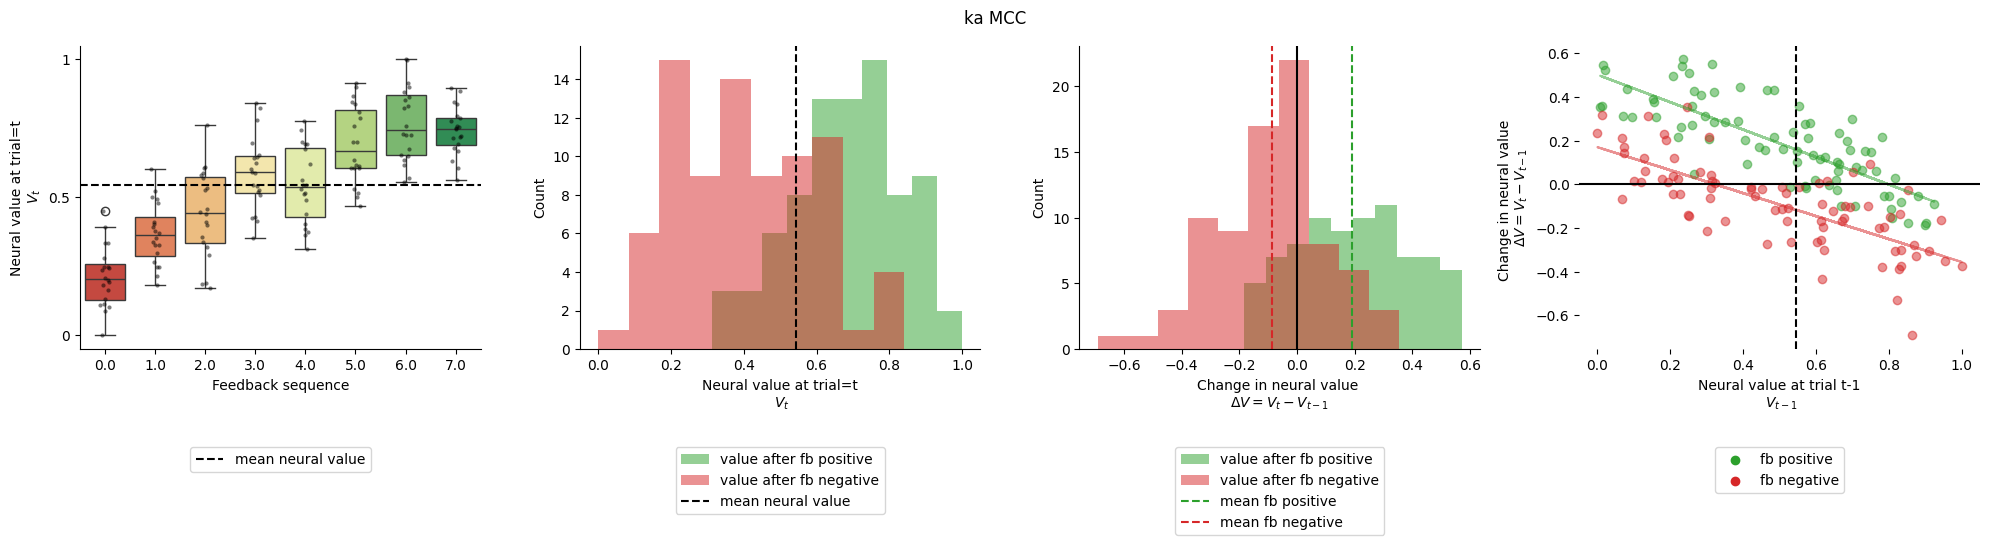

In [ ]:
# distribution of pos and neg feedback along neural value
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
plt.suptitle(f'{monkey} {area}')

# get q_t and q_{t-1}
q_curr = (V_t - np.min(V_t)) / (np.max(V_t) - np.min(V_t)) 
q_prev = (V_t_m1 - np.min(V_t_m1)) / (np.max(V_t_m1) - np.min(V_t_m1))
q_diff = q_curr - q_prev
fb_vector = R_t_m1 
fb_sequence = data_projected.fb_sequence.values

ax = axs[0]

# boxplot of q_curr: x axis is 8 levels of fb_sequence, y axis is q_curr (mean and std and also individual points are shown)
sns.boxplot(x=fb_sequence, y=q_curr, palette='RdYlGn', ax=ax)
sns.stripplot(x=fb_sequence, y=q_curr, color='black', size=3, alpha=0.5, ax=ax)

mean_val = np.mean(q_curr)
ax.axhline(mean_val, color='k', linestyle='--', label='mean neural value')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)

ax.set_xlabel('Feedback sequence')
ax.set_ylabel('Neural value at trial=t\n $V_t$')
#ax.set_ylim(0, 1)
# remove outliers
ax.set_yticks([0, .5, 1])   
ax.set_yticklabels([0, .5, 1])
# legend
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


ax = axs[1]

ax.hist(q_curr[fb_vector == 1], color='tab:green', alpha=.5, label='value after fb positive', bins=10)
ax.hist(q_curr[fb_vector == 0], color='tab:red', alpha=.5, label='value after fb negative', bins=10)

ax.axvline(mean_val, color='k', linestyle='--', label='mean neural value')
# plot mean firing rate
ax.set_xlabel('Neural value at trial=t\n $V_t$')
#ax.set_xlim(0, 1)
ax.set_ylabel('Count')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# distribution of change in value for each feedback
ax = axs[2]

ax.hist(q_diff[fb_vector == 1], color='tab:green', alpha=.5, label='value after fb positive', bins=10)
ax.hist(q_diff[fb_vector == 0], color='tab:red', alpha=.5, label='value after fb negative', bins=10)
# line at 0 and means
ax.axvline(0, color='k', linestyle='-')
ax.axvline(np.mean(q_diff[fb_vector == 1]), color='tab:green', linestyle='--', label='mean fb positive')
ax.axvline(np.mean(q_diff[fb_vector == 0]), color='tab:red', linestyle='--', label='mean fb negative')

ax.set_xlabel('Change in neural value \n$\Delta V = V_t - V_{t-1}$')
#ax.set_xlim(-.7, .7)

ax.set_ylabel('Count')
# legend below plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = axs[3]

# change in value vs RPE
RPE_neural = fb_vector - q_prev

# scatter positive and negative RPEs and fit line
q_prev_temp = q_prev[fb_vector == 1]
q_diff_temp = q_diff[fb_vector == 1]
ax.scatter(q_prev[fb_vector == 1], q_diff[fb_vector == 1], color='tab:green', alpha=.5)
# fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(q_prev_temp, q_diff_temp)
fit_line = slope * q_prev_temp + intercept
ax.plot(q_prev_temp, fit_line, color='tab:green', alpha=.5)

# scatter negative RPEs
q_prev_temp = q_prev[fb_vector == 0]
q_diff_temp = q_diff[fb_vector == 0]
ax.scatter(q_prev[fb_vector == 0], q_diff[fb_vector == 0], color='tab:red', alpha=.5)
# fit line
slope, intercept, r_value, p_value, std_err = stats.linregress(q_prev_temp, q_diff_temp)
fit_line = slope * q_prev_temp + intercept
ax.plot(q_prev_temp, fit_line, color='tab:red', alpha=.5)


# line at 0
ax.axvline(mean_val, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='-')
# legend
ax.scatter([], [], color='tab:green', label='fb positive')
ax.scatter([], [], color='tab:red', label='fb negative')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=1)
ax.set_xlabel('Neural value at trial t-1\n $V_{t-1}$')
ax.set_ylabel('Change in neural value \n$\Delta V = V_t - V_{t-1}$')
#ax.set_ylim(-np.max(np.abs(q_diff))*1.1, np.max(np.abs(q_diff))*1.1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# both axes from -1 to 1

plt.tight_layout()
plt.show()

# Section ...: Behavioral vs neural value

In [ ]:
# time project behavioral vs neural value
behavioral_value = neural_dataset['value_function'].values
neural_value = data_projected.sel(time=3.5).values

# normalize values (minmax
behavioral_value = (behavioral_value - np.mean(behavioral_value)) / np.std(behavioral_value)
neural_value = (neural_value - np.mean(neural_value)) / np.std(neural_value)

fig, axs = plt.subplots(2, 1, figsize=(20, 5), sharex=True)

ax = axs[0]
ax.plot(neural_dataset.trial_id.values, behavioral_value, label='Behavioral value')
ax.plot(data_projected.trial_id.values, neural_value, label='Neural value')

#ax.set_xlim([10, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Value')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()

ax = axs[1]

residuals = neural_value - behavioral_value
#compute rolling mean (10 trials)
residuals = np.convolve(residuals, np.ones(5)/5, mode='same')
ax.plot(neural_dataset.trial_id.values,
        residuals,
        color='black', label='Smoothed residuals (win=10 trials)')
#ax.set_xlim([10, 100])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Residuals')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(0, color='grey', linestyle='--')
ax.set_ylim([-1, 1])
ax.legend()


plt.suptitle(f'{monkey} {session}')
plt.tight_layout()
plt.show()
# plot residuals


KeyError: 'value_function'

In [ ]:
# plot residuals on behavior
residuals_df = pd.DataFrame({'trial_id': neural_dataset.trial_id.values,
                            'residuals': residuals,
                            'behavioral_value': behavioral_value,
                            'neural_value': neural_value})
# merge with behav and residuals: both dataframes ha 'trial_id', and all other columns are different: merge on 'trial_id' and keep all columns from both
behav = behav.reset_index()
residuals_df = residuals_df.merge(behav, on='trial_id', how='left')
residuals_df

In [ ]:
# plot on behavior
#from popy.plotting.plotting_tools import show_target_selection_compact

show_target_selection_compact(residuals_df, 
                              title=f'{monkey} {session}', 
                              background_value='residuals',
                              background_value_lims=[-1, 1],
                              paper_format=False)

## Regress neural value with history of outcomes

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from scipy.optimize import curve_fit
from popy.config import COLORS
import statsmodels.api as sm
from statsmodels.formula.api import glm

plt.rcParams.update({'font.size': 8})


# @title GLM model
def fit_glm(X, y, predictors):
    # Fit GLM on full data
    model_glm = sm.GLM(y, X, family=sm.families.Gaussian())  
    result = model_glm.fit()

    # accuracy and roc-auc w. sklearn
    model_cv = LinearRegression(fit_intercept=False)

    weights = model_cv.fit(X, y).coef_[1:]

    cv_model = cross_validate(model_cv, X, y, cv=10, return_estimator=True, scoring='r2')
    scores_cv = cv_model['test_score']

    # permutation test
    score_perm, permutated_scores, pvalue = permutation_test_score(model_cv, X, y, cv=10, n_permutations=1000, n_jobs=-1, scoring='r2')

    print(f'Monkey: {monkey}, CV accuracy: {scores_cv.mean():.2f} +/- {scores_cv.std():.2f}, Permutation test p-value: {pvalue:.2f}')
    accs = scores_cv.mean()

    # Store the results
    # add statsmodels results
    res = []
    for k, predictor in enumerate(predictors):
        if predictor == 'const': continue
        res.append({
            'monkey': 'ka',
            'variable': predictor,  # predictor, e.g. R_1
            'coeffs': result.params[k],  # coefficient of sklearn CV (mean of K folds)
            'pvalue': result.pvalues[k],  # p-value of that coeff, selon statsmodels
            'if_significant': result.pvalues[k] < 0.05,  # if the p-value is significant        
        })

    df_res = pd.DataFrame(res)

    return df_res, accs

##% plotting
def plot_glm_weights(df_res, plot_significance=False, title=None, saveas=None):
    w = 4
    h = 3
    # Plot the results
    cm = 1/2.54  # centimeters in inches
    fig, ax = plt.subplots()
    fig.set_size_inches(w*cm, h*cm)
    
    if title is not None:
        plt.suptitle(title)

    # scale weights for both monkeys by dividing with the maximum absolute value
    #df_res['coeffs'] = df_res['coeffs'] / df_res.groupby('monkey')['coeffs'].transform('max')

    legend_elements = []  # Store legend elements for each monkey

    # Create scatter plot for each monkey
    for monkey, group in df_res.groupby('monkey'):
        # Convert variable names to numeric x-positions
        x_positions = [list(df_res['variable'].unique()).index(var) for var in group['variable']]
        
        # Get color from COLORS dictionary using monkey key
        current_color = COLORS[monkey.split('_')[-1]]
        linestyle = 'dashdot' if monkey.split('_')[0] == 'simulation' else 'solid'
        alpha = 0.5 if monkey.split('_')[0] == 'simulation' else 1
        
        # Plot points with different fill styles based on significance
        significant = group['pvalue'] < 0.01

        # fit exponential curve of c(a(1-a)^t)
        x = np.arange(0, len(group['coeffs']))
        y = group['coeffs']
        popt, pcov = curve_fit(lambda x, c, a: c * (a * (1 - a) ** x), x, y)
        print(f'{monkey}: c={popt[0]:.2f}, a={popt[1]:.2f}')
        x = np.arange(0, len(group['coeffs']), .1)
        ax.plot(x, popt[0] * (popt[1] * (1 - popt[1]) ** x), color='red', linestyle='--', alpha=0.5)
        
        # Plot significant points (filled)
        ax.scatter(
            [x for x, sig in zip(x_positions, significant) if sig],
            [y for y, sig in zip(group['coeffs'], significant) if sig],
            color=current_color,
            s=30,
            marker='o',
            label=f'{monkey.upper()}, alpha={popt[1]:.2f}',
            alpha=alpha,
        )
        
        # Plot non-significant points (empty)
        ax.scatter(
            [x for x, sig in zip(x_positions, significant) if not sig],
            [y for y, sig in zip(group['coeffs'], significant) if not sig],
            color=current_color,
            s=30,
            marker='o',
            facecolors='none',
            alpha=alpha
        )
        
        # Add lines connecting points
        ax.plot(x_positions, group['coeffs'], color=current_color, alpha=0.5, linestyle=linestyle)

        '''# Create legend elements for this monkey
        legend_elements.extend([
            plt.scatter([], [], color=current_color, s=30, marker='o', label=f'{monkey.upper()}'),
        ])'''

    # Add significance markers to legend
    plt.scatter([], [], color='gray', s=30, marker='o', label='p < 0.01'),
    plt.scatter([], [], color='gray', s=30, marker='o', facecolors='none', label='n.s.')

    # add zero baseline
    #ax.axhline(0, color='black', linewidth=0.5)
    #ax.set_ylim(0, 1.1)

    # Plot settings
    ax.set_ylabel('Reward history weight')
    ax.set_xlabel('Trials in past')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    # Set x-ticks with t-n format
    ax.set_xticks(range(len(df_res['variable'].unique())))
    ax.set_xticklabels([f't-{i+1}' for i in range(len(df_res['variable'].unique()))])

    # Add legend with both monkey names and significance indicators
    ax.legend(frameon=False)

    #plt.tight_layout()
    
    if saveas is not None:
        plt.savefig(saveas, dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
# Fit the GLM
neural_value = data_projected.sel(time=slice(3, 3.5)).values.mean(axis=1)
predictors = ['const', 'R_1', 'R_2', 'R_3']#, 'R_4', 'R_5', 'R_6', 'R_7', 'R_8']#, 'trials_since_switch', 'target', 'RT', 'best_target', 'trial_id']
design_matrix = [np.ones(len(data_projected.trial_id))]  # add constant
for predictor in predictors[1:]:
    design_matrix.append(data_projected[predictor])
design_matrix = np.array(design_matrix).T

df_res, scores = fit_glm(X=design_matrix, y=neural_value, predictors=predictors)

# Plot the results
saveas = 'figs/glm_weights.svg'
plot_glm_weights(df_res,
                 plot_significance=True, 
                 title=None, #f'GLM weights\nMonkey: Ka, ROC-AUC: {scores["ka"].mean():.2f}\nMonkey Po, ROC-AUC: {scores["po"].mean():.2f}',
                 saveas=saveas)


df_res

In [ ]:
'''exploration_trials = neural_value_dataset.phase == 'search'
exploitation_trials = neural_value_dataset.phase == 'repeat'

neural_value_dataset_exploration = neural_value_dataset.where(exploration_trials, drop=True)
neural_value_dataset_exploitation = neural_value_dataset.where(exploitation_trials, drop=True)

green_red_plot_stats(neural_value_dataset_exploration, title='Exploration trials')
green_red_plot_stats(neural_value_dataset_exploitation, title='Exploitation trials')'''

In [ ]:
'''# get neural value for the current trial and the previous one
neural_value = neural_value_dataset.values

# minmax scale 
neural_value = (neural_value - np.min(neural_value)) / (np.max(neural_value) - np.min(neural_value))

q_curr = neural_value[1:]
q_prev = neural_value[:-1]
fb_vector = neural_value_dataset.R_1.values[1:]
phase_vector = neural_value_dataset.phase.values[1:]

df = pd.DataFrame({'q_prev': q_prev, 'q_curr': q_curr, 
                   'q_diff': q_curr - q_prev,
                   'feedback': fb_vector, 'phase': phase_vector})

from matplotlib.ticker import MultipleLocator

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

n_bins = 4
bins = np.linspace(0, 1, n_bins+1)
error_kw = {'alpha': 0.3, 'capsize': 1}
print(bins)

for i in range(n_bins):
    print(f'bin {i}: {bins[i]:.2f} - {bins[i+1]:.2f}')
    # select data in bin
    df_bin = df[(df.q_prev >= bins[i]) & (df.q_prev < bins[i+1])]

    # mean change in value for pos and neg feedback, for exploration and exploitation
    mean_dq_pos_all = df_bin[df_bin.feedback == 1].q_diff.mean()
    std_dq_pos_all = df_bin[df_bin.feedback == 1].q_diff.std()
    mean_dq_neg_all = df_bin[df_bin.feedback == 0].q_diff.mean()
    std_dq_neg_all = df_bin[df_bin.feedback == 0].q_diff.std()

    mean_dq_pos_explore = df_bin[(df_bin.feedback == 1) & (df_bin.phase == 'search')].q_diff.mean()
    mean_dq_neg_explore = df_bin[(df_bin.feedback == 0) & (df_bin.phase == 'search')].q_diff.mean()

    mean_dq_pos_exploit = df_bin[(df_bin.feedback == 1) & (df_bin.phase == 'repeat')].q_diff.mean()
    mean_dq_neg_exploit = df_bin[(df_bin.feedback == 0) & (df_bin.phase == 'repeat')].q_diff.mean()

    ax = axs[0]
    ax.bar(bins[i]-.035, mean_dq_pos_all, width=.07, color='tab:green', alpha=.5, label='fb positive' if i == 0 else '', yerr=std_dq_pos_all, error_kw=error_kw)
    ax.bar(bins[i]+.035, mean_dq_neg_all, width=.07, color='tab:red', alpha=.5, label='fb negative' if i == 0 else '', yerr=std_dq_neg_all, error_kw=error_kw)

    ax = axs[1]
    ax.bar(bins[i]-.05, mean_dq_pos_all, width=.05, color='tab:green', alpha=.5, edgecolor='black',
            label='all trials' if i == 0 else '')
    ax.bar(bins[i], mean_dq_pos_explore, width=.05, color='tab:green', alpha=.5, hatch='///', edgecolor='black',
            label='exploration' if i == 0 else '')
    ax.bar(bins[i]+.05, mean_dq_pos_exploit, width=.05, color='tab:green', alpha=.5, hatch='...', edgecolor='black',
            label='exploitation' if i == 0 else '')

    ax = axs[2]
    ax.bar(bins[i]-.05, mean_dq_neg_all, width=.05, color='tab:red', alpha=.5, edgecolor='black',
            label='all trials' if i == 0 else '')
    ax.bar(bins[i], mean_dq_neg_explore, width=.05, color='tab:red', alpha=.5, hatch='///', edgecolor='black',
            label='exploration' if i == 0 else '')
    ax.bar(bins[i]+.05, mean_dq_neg_exploit, width=.05, color='tab:red', alpha=.5, hatch='..', edgecolor='black',
            label='exploitation' if i == 0 else '')


for ax in axs:
    ax.set_xlabel('Neural value at time=t-1\n $q_{t-1}$')
    ax.set_ylabel('Mean change in neural value\n$\Delta q = q_t - q_{t-1}$')
    ax.set_title(f"monkey: {monkey}, session: {session}")
    ax.axhline(0, color='k', linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # grid with the bins
    ax.xaxis.set_major_locator(MultipleLocator(1/9))
    ax.grid(axis='x', linestyle='--', linewidth=0.5)

    ax.set_xticks(bins[:-1])
    ax.set_xticklabels([f'{bins[i]:.2f} - {bins[i+1]:.2f} ' for i in range(n_bins)], rotation=45)

    ax.legend()

plt.tight_layout()
plt.show()
'''

## Neural value residuals

**When does the neural value representation deviate from the true value?**

In [ ]:
neural_value = data_projected.sel(time=t_best_repres).values
neural_value = (neural_value - np.mean(neural_value)) / np.std(neural_value)  # z-score

behavioral_value = data_projected.value_function.values
behavioral_value = (behavioral_value - np.mean(behavioral_value)) / np.std(behavioral_value)  # z-score

# define residuals based on linear fit (model)
fit_line = np.polyfit(behavioral_value, neural_value, 1)
residuals = neural_value - np.polyval(fit_line, behavioral_value)

In [ ]:
# save residuals to a dataframe
trial_ids = data_projected.trial_id.values

df_residuals = pd.DataFrame({'trial_id': trial_ids, 
                             'behavioral_value': behavioral_value, 
                             'neural_value': neural_value, 
                             'residuals': residuals})
df_residuals['monkey'] = monkey
df_residuals['session'] = session

import pickle
dir = '/Users/zsombi/Library/CloudStorage/OneDrive-Personal/PoPy/data/results'
fname = f'{monkey}_{session}_residuals.pkl'
with open(os.path.join(dir, fname), 'wb') as f:
    pickle.dump(df_residuals, f)

df_residuals


In [ ]:
plot_residuals(behavioral_value, neural_value, residuals, fit_line, monkey, session)

In [ ]:
plot_residuals_time(data_projected, residuals, monkey, session)

---
# Section 3: Neural value predicts switch

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
X = data_projected.sel(time=t_best_repres).data
y = data_projected.switch.values.astype(int)


In [ ]:
bins = np.linspace(X.min(), X.max(), 20 + 1)

plt.hist(X[y == 0], bins=bins, alpha=.5, label='stay')
plt.hist(X[y == 1], bins=bins, alpha=.5, label='switch')

In [ ]:

# Assuming X and y are your input arrays
# X: numeric values
# y: binary values (0 or 1)

# Step 1: Create bins
num_bins = 20  # You can adjust this value
bins = np.linspace(X.min(), X.max(), num_bins + 1)
n_perm = 1000

res = np.zeros((2, num_bins-1, n_perm))  # 2 classes, num_bins-1 bins, n_perm permutations
for i_perm in range(n_perm):
    X_temp, y_temp = RandomUnderSampler().fit_resample(X.reshape(-1, 1), y)
    X_temp = X_temp.squeeze()
    
    for i_bins in range(num_bins-1):
        mask = (X >= bins[i_bins]) & (X < bins[i_bins+1])
        ones_in_bin = np.sum(y[mask] == 1)
        zeros_in_bin = np.sum(y[mask] == 0)
        
        res[1, i_bins, i_perm] = ones_in_bin
        res[0, i_bins, i_perm] = zeros_in_bin

# Step 2: Compute the weighted ratios
res = res.mean(axis=2)
ratios = res[1] / res[0]

plt.figure(figsize=(5, 3))
plt.plot(ratios)
plt.xlabel('Neural value')
plt.ylabel('Ratio of switch trials')
plt.title(f'Monkey {monkey}, session {session}')
plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# get data - X: value function, y: switch

X = data_projected.sel(time=t_best_repres).data.reshape(-1, 1)
y = data_projected.switch.values.astype(int)

print(f'X shape: {X.shape}, y shape: {y.shape}')

# compute probab switch for each bin

# run the model for random undersampling 1000 times, and store the probabs of switch
probab_of_switch_full = []  # ratio of y=0 and y=1, in the subset of x with window size of bin_size
n_bins = 10
x_bins = np.linspace(X.min(), X.max(), n_bins + 1)

for i in range(1000):
    # balance classes by undersampling majority class
    X_temp, y_temp = RandomUnderSampler().fit_resample(X, y)

    probab_of_switch_temp = []  # probab of switch in target for each bin
    for j in range(len(x_bins)-1):
        x_min = x_bins[j]
        x_max = x_bins[j+1]

        ids = np.argwhere((X_temp >= x_min) & (X_temp < x_max))[:, 0]

        if len(ids) > 0:
            proba_switch = np.mean(y_temp[ids])

        else:
            proba_switch = np.nan

        probab_of_switch_temp.append(proba_switch)

    probab_of_switch_full.append(probab_of_switch_temp)

probab_of_switch_full = np.array(probab_of_switch_full)


# prepare data
#X = session_data_pooled.value_function.values.reshape(-1, 1)
#y = session_data_pooled.switch.values
#y = y.astype(int)  # convert y to 0 and 1
#z = session_data_pooled.phase.values

# fig, axs = plt.subplots(3, 1, figsize=(8, 8))

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(12*cm, 11*cm))
# fontsize 12
plt.rcParams.update({'font.size': 12})

# plot distribution of q-values, groupped by switch no-switch
"""ax = axs[0]
X_temp, y_temp = RandomUnderSampler().fit_resample(X, y)
bins = x_bins

# plot q-values for switch
ax.hist(X_temp[y_temp==1], bins=bins, alpha=0.5, label='switch trials')
# plot q-values for no-switch
ax.hist(X_temp[y_temp==0], bins=bins, alpha=0.5, label='no-switch trials')

ax.set_ylabel('count')
ax.set_xlabel('Q-value')
ax.legend()"""

# first plot : probab of switch
#ax = axs[1]
# plot mean
ax.plot(x_bins[:-1], np.mean(probab_of_switch_full, axis=0), color='black', marker='o', linewidth=2, markersize=8)
# plot std
ax.fill_between(x_bins[:-1], np.mean(probab_of_switch_full, axis=0) - np.std(probab_of_switch_full, axis=0), np.mean(probab_of_switch_full, axis=0) + np.std(probab_of_switch_full, axis=0), color='black', alpha=0.2)

# horizontal dashed lines at .85 and .15
ax.axhline(.85, color='grey', linestyle='dashed', label='85% certainty')
ax.axhline(.15, color='grey', linestyle='dashed')
ax.set_ylabel('Probability of switch', fontsize=12)
ax.set_xlabel('Neural value estimate', fontsize=12)
ax.set_ylim([-0.05, 1.05])
#ax.grid()
# hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

# plot decodability of switch based on Q-value
"""ax = axs[2]
decodability_of_switch_full = np.abs(probab_of_switch_full-.5)+.5
ax.plot(x_bins[:-1], np.mean(decodability_of_switch_full, axis=0), color='red', marker='o')
# plot std
ax.fill_between(x_bins[:-1], np.mean(decodability_of_switch_full, axis=0) - np.std(decodability_of_switch_full, axis=0), np.mean(decodability_of_switch_full, axis=0) + np.std(decodability_of_switch_full, axis=0), color='red', alpha=0.2)

# horizontal dashed lines at .85 and .15
ax.axhline(.85, color='grey', linestyle='dashed', label='85% certainty')
ax.set_ylim([0.45, 1.05])

ax.set_ylabel('decodability of switch')
ax.set_xlabel('Q-value')"""

"""plt.suptitle(f'Action value as a predictor of switch\n'
            f'monkey: {monkey}')"""

#ax.grid()
plt.title(f'{monkey} {session}')
plt.tight_layout()
# legend no box
plt.legend(frameon=False)
plt.show()

# save as vector graphics
fig.savefig(os.path.join(PATH, 'figs', 'cosyne', f'neural_action_value_switch_{session}.svg'), format='svg', dpi=300)

---
# Section 3: OLD CODE TO REVIEW

In [ ]:
# slow fluctuations of reaction times
reaction_time = data_projected.RT.values
reaction_time_smooth = np.convolve(reaction_time, np.ones(10)/10, mode='same')

fig, ax = plt.subplots()

ax.plot(data_projected.trial_id, reaction_time, color='grey', alpha=.5, label='Reaction time (s)')
ax.plot(data_projected.trial_id, reaction_time_smooth, color='black', label='Smoothed reaction time (win=10 trials)')
ax.axhline(0, color='grey', linestyle='--')

ax.set_ylim([0.2, .5])

ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Trial')
ax.set_ylabel('Reaction time')

plt.suptitle(f'{monkey} {session}')

In [ ]:
''''# show behavior
session_data['residuals'] = residuals_smooth
show_target_selection(session_data, background_value='residuals', title=f'{monkey} {session}')
'''

In [ ]:
data_projected

In [ ]:
data

In [ ]:
# correlate history of outcomes with neural value
exploration_limit = 6
results = []

# Calculate the probability of switching for each history
fb_sequences = np.unique(data_projected.fb_sequence)
for fb_sequence in fb_sequences:
    data = data_projected.sel(time=t_best_repres, trial_id=data_projected.fb_sequence == fb_sequence)
    data = data.sel(trial_id=data.trials_since_switch >= 3)

    # Calculate the probability of switching for all trials
    mean_neural_value = np.mean(data.values)
    results.append({'history': fb_sequence, 'mean_value': mean_neural_value, 'data': 'all_trials', 'n_trials': len(data)})

    # Calculate the probability of switching for exploratory trials (i.e. where trials_since_switch < 6)
    data_temp = data.sel(trial_id=data.trials_since_switch < exploration_limit)
    proba_switch_exploratory = np.mean(data_temp.values)
    results.append({'history': fb_sequence, 'mean_value': proba_switch_exploratory, 'data': 'exploratory_trials', 'n_trials': len(data_temp)})

    # Calculate the probability of switching for exploitatory trials (i.e. where trials_since_switch >= 6)
    data_temp = data.sel(trial_id=data.trials_since_switch >= exploration_limit)
    proba_switch_exploitatory = np.mean(data_temp.values)
    results.append({'history': fb_sequence, 'mean_value': proba_switch_exploitatory, 'data': 'exploitatory_trials', 'n_trials': len(data_temp)})

# Convert the list of results to a DataFrame
df_proba_switch = pd.DataFrame(results)

df_proba_switch

# plot the results
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(data=df_proba_switch, x='history', y='mean_value', hue='data', ax=ax)
ax.set_title(f'{monkey} {session}')
ax.set_ylabel('Neural value')
ax.set_xlabel('History')
plt.show()


In [ ]:
X = np.stack([data_projected.R_1.values, data_projected.R_2.values, data_projected.R_3.values], axis=1)
X

In [ ]:
# correlate history of outcomes with neural value
exploration_limit = 6
results = []

# Calculate the probability of switching for each history
data = data_projected.sel(time=t_best_repres, trial_id=data_projected.trials_since_switch >= 3)

# Calculate the probability of switching for all trials
y = data.values
X = np.stack([data.R_1.values, data.R_2.values, data.R_3.values, data.R_4.values], axis=1)
clf = LinearRegression()
coeffs = clf.fit(X, y).coef_
results.append({'coeffs': coeffs, 'data': 'all_trials', 'n_trials': len(data)})

# Calculate the probability of switching for exploratory trials (i.e. where trials_since_switch < 6)
data_temp = data.sel(trial_id=data.trials_since_switch < exploration_limit)
y = data_temp.values
X = np.stack([data_temp.R_1.values, data_temp.R_2.values, data_temp.R_3.values, data_temp.R_4.values], axis=1)
clf = LinearRegression()
coeffs = clf.fit(X, y).coef_
results.append({'coeffs': coeffs, 'data': 'exploratory_trials', 'n_trials': len(data_temp)})

# Calculate the probability of switching for exploitatory trials (i.e. where trials_since_switch >= 6)
data_temp = data.sel(trial_id=data.trials_since_switch >= exploration_limit)
y = data_temp.values
X = np.stack([data_temp.R_1.values, data_temp.R_2.values, data_temp.R_3.values, data_temp.R_4.values], axis=1)
clf = LinearRegression()
coeffs = clf.fit(X, y).coef_
results.append({'coeffs': coeffs, 'data': 'exploitatory_trials', 'n_trials': len(data_temp)})

# Convert the list of results to a DataFrame
df_proba_switch = pd.DataFrame(results)

df_proba_switch

# plot the results
fig, ax = plt.subplots(figsize=(5, 3))
for i, data in enumerate(df_proba_switch.coeffs):
    ax.plot(data, label=df_proba_switch.data[i], marker='o')
ax.set_title(f'{monkey} {session}')
ax.set_ylabel('regression coeffs')
ax.set_xlabel('History')
ax.legend()


In [ ]:
y

# Find subspace of previous feedbacks

## Fitting decoders to get weights (no cross-val)

In [ ]:
# run decoding for each condition and store results in df
window_len = .4
step_len = .1
# add new column for rpe

weights = {}

weights['fb'] = linear_decoding(neural_data, session_data, 'feedback', area='MCC',
                                  K_fold=5, window_len=window_len, step_len=step_len, 
                                  starts_on='trial_start', ends_on='trial_end')

weights['R_1'] = linear_decoding(neural_data, session_data, 'R_1', area='MCC', mode='weights',
                                  K_fold=5, window_len=window_len, step_len=step_len, 
                                  starts_on='trial_start', ends_on='trial_end')

weights['R_2'] = linear_decoding(neural_data, session_data, 'R_2', area='MCC', mode='weights',
                                  K_fold=5, window_len=window_len, step_len=step_len, 
                                  starts_on='trial_start', ends_on='trial_end')

weights['R_3'] = linear_decoding(neural_data, session_data, 'R_3', area='MCC', mode='weights',
                                  K_fold=5, window_len=window_len, step_len=step_len, 
                                  starts_on='trial_start', ends_on='trial_end')

weights['R_4'] = linear_decoding(neural_data, session_data, 'R_4', area='MCC', mode='weights',
                                  K_fold=5, window_len=window_len, step_len=step_len, 
                                  starts_on='trial_start', ends_on='trial_end')


In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(8, 8))

for i, target in enumerate(list(weights.keys())):
    axs[i].plot(weights[target]['scores'])
    axs[i].axvline(350*step_len, color='red', linestyle='dashed', label='feedback')
    axs[i].axhline(.5, color='grey', linestyle='dashed', label='feedback')

plt.show()

## Compare subspaces for t-1, t-2, ...

In [ ]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * (180/np.pi)
    return 90 - np.abs((-1 * angle) + 90)

# decoder axes
angles_full = np.empty((weights['fb']['weights'].shape[1], weights['fb']['weights'].shape[1]))
for t_1 in range(weights['fb']['weights'].shape[1]):
    for t_2 in range(weights['fb']['weights'].shape[1]):
        #best_bin = np.argmax(scores_R_1)
        angles_full[t_1, t_2] = angle_between(weights['R_1']['weights'][:, t_1], weights['R_2']['weights'][:, t_2])

im = plt.imshow(angles_full, origin='lower')
plt.axvline(350*step_len, color='red', linestyle='dashed', label='feedback')
plt.axhline(350*step_len, color='red', linestyle='dashed', label='feedback')
plt.colorbar()


## Find subspace of best representation

In [ ]:
# plot decodability to see times of best decodability of feedback and value function

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(weights['fb']['scores'])
axs[1].plot(weights['R_1']['scores'])

axs[0].axvline(350*step_len, color='red', linestyle='dashed', label='feedback')
axs[1].axvline(350*step_len, color='red', linestyle='dashed', label='feedback')

axs[0].axvline(np.argmax(weights['fb']['scores']), color='black', label='time of best decodability')
axs[1].axvline(np.argmax(weights['R_1']['scores']), color='black', label='time of best decodability')

axs[0].set_title('decoding of current feedback')
axs[1].set_title('decoding of previous feedback')

#plt.suptitle(f'angle between best decoder axes: {angle_between(weights["fb"]['weights'][:, np.argmax(weights["fb"]['scores'])], weights["R_1"]['weights'][:, np.argmax(weights["R_1"]['scores'])]):.2f} deg, {monkey} {session} MCC')
plt.tight_layout()

axs[0].legend()
axs[1].legend()

# Get Neural value

In [ ]:
#bin_best_repres = np.argmax(scores_R_1)
subspace_of = 'R_1'

bin_best_repres = int(300 * step_len)
value_function_subspace = weights[subspace_of]['weights'][:, bin_best_repres]

t_best_repres = int(bin_best_repres/step_len)

## Projecting activity to best subspace

In [ ]:
# project to axis
data_projected = np.array([
    data_temp.T @ value_function_subspace for data_temp in data
])

# prepare data
Q_n = data_projected[:, t_best_repres].reshape(-1, 1)
Q_n = (Q_n - Q_n.min()) / (Q_n.max() - Q_n.min())
session_data['neural_action_value'] = Q_n
session_data

### Plot based on Previous outcomes

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

colors = ['grey', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue']
alphas = [1, 1, .8, .6, .4]

full_mean = np.mean(data_projected, axis=0)
for i, col in enumerate(['feedback', 'R_1', 'R_2', 'R_3', 'R_4']):
    pos_mean = np.mean(data_projected[session_data[col] == True], axis=0)
    neg_mean = np.mean(data_projected[session_data[col] == False], axis=0)

    ax[0].plot(pos_mean, color=colors[i], label=col, alpha=alphas[i])
    ax[0].plot(neg_mean, color=colors[i], linestyle='dashed', alpha=alphas[i])
    ax[0].axvline(350, color='red', linestyle='dashed')

    ax[1].plot(pos_mean - full_mean, color=colors[i], label=col, alpha=alphas[i])
    ax[1].plot(neg_mean - full_mean, color=colors[i], linestyle='dashed', alpha=alphas[i])
    ax[1].axhline(0, color='grey', alpha=.1)
    ax[1].axvline(350, color='red', linestyle='dashed')

ax[1].plot([], [], color='black', label='positive fb')
ax[1].plot([], [], color='black', linestyle='dashed', label='negative fb')
ax[0].plot([], [], color='black', label='positive fb')
ax[0].plot([], [], color='black', linestyle='dashed', label='negative fb')

ax[0].axvline(t_best_repres, color='black', label='sampling time neural value')
ax[1].axvline(t_best_repres, color='black', label='sampling time neural value')

ax[0].set_title('trial averaged trajectories')
ax[1].set_title('trial averaged trajectories, distance from mean')

ax[0].legend()
ax[1].legend()

plt.suptitle(f'subspace of {subspace_of}, {monkey} {session}')

### Plot based on sequence of outcomes

In [ ]:
# project to axis
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# bwr colormap, n=8 sampples
colors = [plt.cm.bwr(i) for i in np.linspace(0, 1, len(session_data['fb_sequence'].unique()))][::-1]
alphas = [1-i for i in np.linspace(0, 1, len(session_data['fb_sequence'].unique()))]
labels = ["[-, -, -]", "[+, -, -]", "[-, +, -]", "[+, +, -]", "[-, -, +]", "[+, -, +]", "[-, +, +]", "[+, +, +]"]

full_mean = np.mean(data_projected, axis=0)
for i, label in enumerate(np.sort(session_data['fb_sequence'].unique())):
    class_mean = np.mean(data_projected[session_data['fb_sequence'] == label], axis=0)

    ax[0].plot(class_mean, label=labels[i], color=colors[i])
    ax[0].axvline(350, color='red', linestyle='dashed')

    ax[1].plot(class_mean - full_mean, color=colors[i], label=label)
    ax[1].axhline(0, color='grey', alpha=.1)
    ax[1].axvline(350, color='red', linestyle='dashed')

ax[0].axvline(t_best_repres, color='black', label='sampling time neural value')
ax[1].axvline(t_best_repres, color='black', label='sampling time neural value')

ax[0].set_title('trial averaged trajectories')
ax[1].set_title('trial averaged trajectories, distance from mean')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.suptitle(f'subspace of {subspace_of}, {monkey} {session}')

# Regress Neural value function with history of rewards

In [ ]:
# get y = Qn neural value function and history of rewards vector
len_hist = 8
y = session_data[len_hist+1:]['neural_action_value'].values
X = np.empty((len(session_data[len_hist+1:].index), len_hist))
for i, index in enumerate(session_data[len_hist+1:].index):
    X[i, :] = session_data.loc[index-len_hist:index-1, 'feedback'].values
X = X[:, ::-1]

# do linear regression to see if there is a relationship between the two
scores_train = []
scores_test = []
coeffs = []
for i in range(1000):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
    reg = LinearRegression().fit(x_train, y_train)
    scores_train.append(reg.score(x_train, y_train))
    scores_test.append(reg.score(x_test, y_test))
    coeffs.append(reg.coef_)

scores_train = np.mean(np.array(scores_train))
scores_test = np.mean(np.array(scores_test))
coeffs = np.array(coeffs)

import statsmodels.api as sm

# fit model
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

scores_full = results.rsquared
weights = results.params[1:]
p_vals = results.pvalues[1:]

# fit exponential curve
from scipy.optimize import curve_fit
def exp_decay(x, a, b, c):
    return a * np.exp(-b * x) + c
exp_params, _ =  curve_fit(exp_decay, np.arange(len(weights)), weights)

print(f'R^2 train: {scores_train:.2f}')
print(f'R^2 test: {scores_test:.2f}')
print(f'R^2 full: {scores_full:.2f}')

# loop backwards
#for i in range(len(coeffs)):
#   plt.plot(coeffs[i, ::-1], color='grey', alpha=.1)
plt.plot(weights, color='black', label='full data')
# put asterisk over significant
for i in range(len(weights)):
    if p_vals[i] < .01*len(weights):
        plt.plot(i, weights[i], marker='*', markersize=10, color='black', linestyle='none')
plt.plot(np.mean(coeffs, axis=0), marker='o', label='regression coefficients')

x_ticks = ['t-1', 't-2', 't-3', 't-4', 't-5', 't-6', 't-7', 't-8']
plt.xticks(np.arange(len(x_ticks)), x_ticks)

plt.xlabel('time steps back')
plt.ylabel('regression coefficient')


In [ ]:
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(12*cm, 11*cm))
# font 12
plt.rcParams.update({'font.size': 12})
# plot all weights (mean and std) with scatter and bars
ax.plot(weights, marker='o', color='black', label='weights', linewidth=3, markersize=10)

# mark significant 
p_lim = 0.01
#mark with asterisk
for i, p_val in enumerate(p_vals):
    if p_val < p_lim:
        ax.annotate('*', xy=(i, weights[i]), xytext=(i, weights[i]+.01), fontsize=16, ha='center')

'''
ax.scatter(np.arange(len(p_vals))[p_vals < p_lim],
           weights[p_vals < p_lim]+.5, marker='*',
           color='red', label=f'significant (p < {p_lim})')
'''
# plot exponential curve
ax.plot(exp_decay(np.arange(len(weights)), *exp_params), color='red', linestyle='--', label='exp. decay')
# dashed line at 0
ax.axhline(0, color='k', linestyle='--')
# print exp decay rate on plot, red
ax.text(0.5, 0.55, f'exp. decay rate: λ = {exp_params[1]:.2f}', transform=ax.transAxes, color='tab:red')

# set xtick as 'trial N-x'
ax.set_xticks(np.arange(len(weights)))
ax.set_xticklabels([f'β_{i}' for i in range(1, len(weights)+1)])

# labels
ax.set_xlabel('trial into past', fontsize=12)
ax.set_ylabel('Reward history weight (β)', fontsize=12)
#ax.set_ylim([-0.1, 1.05])
# title
#ax.set_title(f"monkey: {monkey}, session: {session}")
#plt.grid()
# hide top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# legend, no frame
plt.legend(frameon=False)
plt.show()

# print exponential curve parameters
print('')
print(f'Exponential curve: a * np.exp(-b * x) + c\n',
      f'a={exp_params[0]:.2f}, b={exp_params[1]:.2f}, c={exp_params[2]:.2f}')

# save as vector graphics
#fig.savefig(f'/Users/zsombi/OneDrive/PoPy/figs/neurofrance/weights_neural.svg', format='svg') 

# Neural value function predicts behavior a_t = g(Qn_t)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

switch = session_data.switch.values
target_value = session_data.Q_n.values  * -1 + 1 # invert the value function, so that the switch trials have a higher value

# ROC curve
fpr, tpr, _ = roc_curve(switch, target_value)
# AUC
auc = roc_auc_score(switch, target_value)

cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(12*cm, 11*cm))
# set font size 12
plt.rcParams.update({'font.size': 12})

# plot unbalanced
ax.plot(fpr, tpr, color='red', label='ROC curve', linewidth=3)
# fill under the curve
ax.fill_between(fpr, tpr, color='grey', alpha=.1)

# print AUC
ax.text(0.7, 0.35, f'AuC: {auc:.2f}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

"""
plt.plot(accs_mean[1], accs_mean[0], color='green', label='accuracy (balanced)')
for i in range(len(accs)):
    plt.plot(accs[i][1], accs[i][0], color='green', alpha=.1)
"""# plot balanced
#plt.plot(fprs_mean, tprs_mean, color='blue', label='ROC curve (balanced)')
#plt.fill_between(fprs_mean, tprs_mean - tprs_std, tprs_mean + tprs_std, color='blue', alpha=.1)

# plot chance
ax.plot([0, 1], [0, 1], color='grey', linestyle='dashed')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
"""ax.set_title(f'ROC curve\n'
          f'AUC (unbalanced): {auc:.2f}'
          f'monkey: {monkey}')"""

# hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# legend, no box
ax.legend(loc='lower right', frameon=False)

#plt.grid()
plt.show()

#fig.savefig(f'/Users/zsombi/OneDrive/PoPy/figs/neurofrance/roc_neural.svg', format='svg') 


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# plot
bin_size = .1  # the size of the bins for the Q-values over which the probability of switch is calculated

# prepare data
X = session_data.Q_n.values.reshape(-1, 1)

y = session_data.switch.values
y = y.astype(int)  # convert y to 0 and 1

# run the model for random undersampling 1000 times, and store the probabs of switch
probab_of_switch_full = []  # ratio of y=0 and y=1, in the subset of x with window size of bin_size
x_bins = np.arange(np.min(X), np.max(X)+.001, bin_size)  # the bins for the Q-values

for i in range(1000):
    # balance classes by undersampling majority class
    X_temp, y_temp = RandomUnderSampler().fit_resample(X, y)

    probab_of_switch_temp = []  # probab of switch in target for each bin
    for j in range(len(x_bins)-1):
        x_min = x_bins[j]
        x_max = x_bins[j+1]

        ids = np.argwhere((X_temp >= x_min) & (X_temp < x_max))[:, 0]
        if len(ids) == 0:
            probab_of_switch_temp.append(np.nan)
        else:
            probab_of_switch_temp.append(np.mean(y_temp[ids]))
    probab_of_switch_full.append(probab_of_switch_temp)
probab_of_switch_full = np.array(probab_of_switch_full)

probab_of_switch_mean = np.empty(probab_of_switch_full.shape[1])
std_mean = np.empty(probab_of_switch_full.shape[1])
for i in range(probab_of_switch_full.shape[1]):
    p_temp = probab_of_switch_full[:, i]
    p_temp = p_temp[~np.isnan(p_temp)]
    probab_of_switch_mean[i] = np.mean(p_temp)
    std_mean[i] = np.std(p_temp)

X_temp, y_temp = RandomUnderSampler().fit_resample(X, y)
bins = x_bins

fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# plot distribution of q-values, groupped by switch no-switch
ax = axs[0]
# plot q-values for switch
ax.hist(X_temp[y_temp==1], bins=bins, alpha=0.5, label='switch trials')
# plot q-values for no-switch
ax.hist(X_temp[y_temp==0], bins=bins, alpha=0.5, label='no-switch trials')

ax.set_ylabel('count')
ax.set_xlabel('neural Action-value')
ax.legend()

# first plot : probab of switch
ax = axs[1]
# plot mean
ax.plot(x_bins[:-1], probab_of_switch_mean, color='red', marker='o')
ax.fill_between(x_bins[:-1], probab_of_switch_mean - std_mean, probab_of_switch_mean + std_mean, color='red', alpha=0.2)
# plot std
#ax.fill_between(x_bins[:-1], probab_of_switch_mean - np.std(probab_of_switch_full, axis=0), np.mean(probab_of_switch_full, axis=0) + np.std(probab_of_switch_full, axis=0), color='red', alpha=0.2)

# horizontal dashed lines at .85 and .15
ax.axhline(.85, color='grey', linestyle='dashed', label='85% certainty')
ax.axhline(.15, color='grey', linestyle='dashed')
ax.set_ylabel('probability of switch')
ax.set_xlabel('neural Action-value')
ax.set_ylim([-0.05, 1.05])
#ax.grid()
ax.legend()

# plot decodability of switch based on Q-value
ax = axs[2]
decodability_of_switch = np.abs(probab_of_switch_mean-.5)+.5
ax.plot(x_bins[:-1], decodability_of_switch, color='red', marker='o')
# plot std
#ax.fill_between(x_bins[:-1], np.mean(decodability_of_switch_full, axis=0) - np.std(decodability_of_switch_full, axis=0), np.mean(decodability_of_switch_full, axis=0) + np.std(decodability_of_switch_full, axis=0), color='red', alpha=0.2)

# horizontal dashed lines at .85 and .15
ax.axhline(.85, color='grey', linestyle='dashed', label='85% certainty')

ax.set_ylabel('decodability of switch')
ax.set_xlabel('neural Action-value')

plt.suptitle(f'neural Action-value as a predictor of switch\n'
            f'monkey: {monkey} session: {session}')

ax.set_ylim([0.45, 1.05])
#ax.grid()
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
cm = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(12*cm, 11*cm))
# font 12
plt.rcParams.update({'font.size': 12})

ax.plot(x_bins[:-1], probab_of_switch_mean, color='black', marker='o', linewidth=2, markersize=8)
ax.fill_between(x_bins[:-1], probab_of_switch_mean - std_mean, 
probab_of_switch_mean + std_mean, color='black', alpha=0.2)

# horizontal dashed lines at .85 and .15
ax.axhline(.85, color='grey', linestyle='dashed', label='85% certainty')
ax.axhline(.15, color='grey', linestyle='dashed')
ax.set_ylabel('Probability of switch', fontsize=12)
ax.set_xlabel('Action value estimate', fontsize=12)
ax.set_ylim([-0.05, 1.05])
#ax.grid()
# hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

"""
plt.suptitle(f'monkey: {monkey}, session: {session}')
"""
#ax.grid()
plt.tight_layout()
plt.legend()
plt.show()

# save as vector graphics
#fig.savefig(f'/Users/zsombi/OneDrive/PoPy/figs/neurofrance/prob_switch_neural.svg', format='svg') 